In [1]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['C:\\Users\\user\\PycharmProjects\\Open_Close_GNN'])

Python 3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)] on win32


In [2]:
from model.dataset import OpenCloseDataset
from model.gnn_model import GCN, GATv2
import os
from model.utils import train, device, train_epoch, eval_epoch, cross_val
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch_geometric.loader import DataLoader

from captum.attr import Saliency

from seaborn import heatmap

In [3]:
close_file = np.load('../data/new/raw/close_84.npy') 
open_file  = np.load('../data/new/raw/open_84.npy')

noised_close = np.load('../data/new/raw/noised_close.npy')
noised_open  = np.load('../data/new/raw/noised_open.npy')

In [4]:
full_dataset = OpenCloseDataset(datafolder='../data/new', 
                                open_file=open_file, close_file=close_file, 
                                reload=True, k_degree=50, 
                                noise_n=25, noise_close=noised_close, noise_open=noised_open)

Processing...
Done!


In [5]:
test_idx = np.random.choice(np.arange(84*2, dtype=int), 20).tolist()
train_idx = np.delete(np.arange(len(full_dataset)), test_idx).tolist()
test_dataset = full_dataset[test_idx[:10]]
train_dataset = full_dataset[train_idx]
val_dataset = full_dataset[test_idx[10:]]

In [6]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [7]:
model = GCN(full_dataset.num_features, channels=[128, 32], dropout=0.5).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 10
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1, last_epoch=-1, verbose=True)
sum(p.numel() for p in model.parameters())

Adjusting learning rate of group 0 to 1.0000e-03.


58594

In [8]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, 
                scheduler=None, save_best=True, path_to_save='../weights/gcn_128_32_05.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 0.0797, Test Loss 0.1222, Train Acc: 0.6929, Test Acc: 0.8125
Test precision: 0.7857, Test recall: 1.0000
Epoch: 002, Train Loss: 0.0557, Test Loss 0.0957, Train Acc: 0.8900, Test Acc: 0.8125
Test precision: 0.7857, Test recall: 1.0000
Epoch: 003, Train Loss: 0.0299, Test Loss 0.0646, Train Acc: 0.9800, Test Acc: 0.8750
Test precision: 0.8571, Test recall: 1.0000
Epoch: 004, Train Loss: 0.0152, Test Loss 0.0494, Train Acc: 0.9950, Test Acc: 1.0000
Test precision: 0.5000, Test recall: 0.5000
Epoch: 005, Train Loss: 0.0064, Test Loss 0.0353, Train Acc: 1.0000, Test Acc: 0.9375
Test precision: 0.9167, Test recall: 1.0000
Epoch: 006, Train Loss: 0.0036, Test Loss 0.0303, Train Acc: 1.0000, Test Acc: 0.9375
Test precision: 0.9167, Test recall: 1.0000
Epoch: 007, Train Loss: 0.0016, Test Loss 0.0448, Train Acc: 1.0000, Test Acc: 0.9375
Test precision: 0.4286, Test recall: 0.5000
Epoch: 008, Train Loss: 0.0010, Test Loss 0.0268, Train Acc: 1.0000, Test Acc: 0.9375
Test

In [9]:
test_loader = DataLoader(test_dataset)
eval_epoch(test_loader, model, loss)
# loss, acc, precision, recall

(0.7315712939132937, 0.7, 0.2, 0.2)

In [21]:
[i for i, en in enumerate(test_dataset) if en.y == 1]

[1, 4, 6]

1


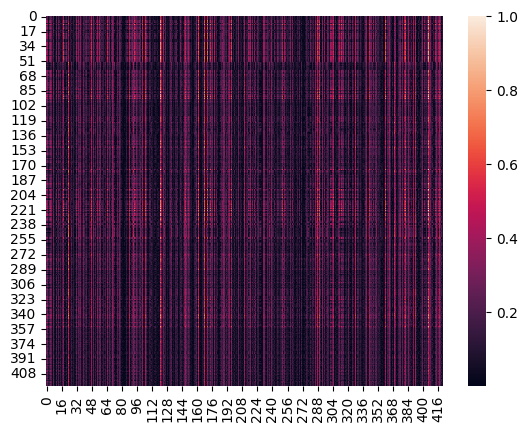

In [23]:
idx = 6
print(test_dataset[idx].y.item())
sal = Saliency(model.to('cpu'))
mask = sal.attribute(test_dataset[idx].x.requires_grad_(), 
                     additional_forward_args=(test_dataset[idx].edge_index, test_dataset[idx].edge_attr, test_dataset[idx].batch),
                     target=test_dataset[idx].y)

edge_mask = np.abs(mask.cpu().detach().numpy())
if edge_mask.max() > 0:  # avoid division by zero
    edge_mask = edge_mask / edge_mask.max()

heatmap(edge_mask);

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\nilearn\__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
C:\Users\user\AppData\Roaming\Python\Python37\site-packages\nilearn\plotting\displays\_projectors.py:166: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "


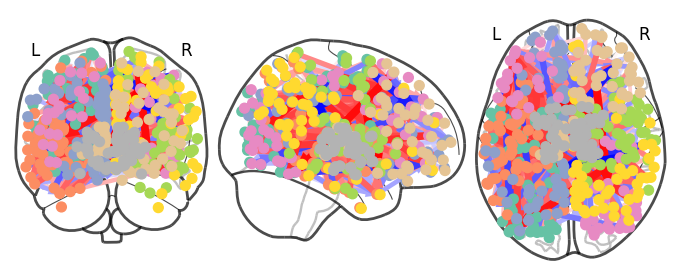

In [24]:
from nilearn.plotting import plot_connectome
import pandas as pd

hcp = pd.read_excel('../data/HCPex_sorted.xlsx')
hcp.drop([256, 257, 258, 259], inplace=True)

salient_connections = np.zeros((422, 422))
for i in range(422):
    salient_connections[i] = edge_mask[i] > 0.6

plot_connectome(salient_connections * test_dataset[0].x.numpy(), hcp[['X', 'Y', 'Z']].values);